<h1 style="text-align:center;"><u><b>Unstructured Data Analytics - Assignment 2<b></u></h1>
Team Members:
Sukhada Virkar, Ruizhi Ding, Abhiram Iyengar, Anshul Joshi, Akhil Sourav


# Task A

In [59]:
!pip install nltk

In [60]:
import requests
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import combinations
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [61]:

# Define API endpoint and headers
api_url = "https://beta.ratebeer.com/v1/api/graphql/"
http_headers = {
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.8',
    'content-type': 'application/json',
    'locale': 'en',
    'origin': 'https://www.ratebeer.com',
    'referer': 'https://www.ratebeer.com/',
    'sec-fetch-mode': 'cors',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'
}

# Corrected payload to retrieve beers data
beer_payload = json.dumps({
    "query": """
        query {
            topBeersSearch(input: {
                beerCreatedWithin: ALL,
                reviewCreatedWithin: ALL,
                orderBy: AVERAGE_SCORE,
                orderByDirection: DESC
            }) {
                items {
                    id
                    name
                    ratingsCount
                    normalizedAverageReview
                    abv
                    overallScore
                    style { name }
                    brewer { country { name } }
                }
            }
        }
    """
})

# Make request for beers
beer_response = requests.post(api_url, headers=http_headers, data=beer_payload)

# Check if the response status is successful and inspect the data
if beer_response.status_code != 200:
    print(f"Error: Failed to fetch beers. Status code: {beer_response.status_code}")
    print(f"Response: {beer_response.text}")
else:
    beer_data = json.loads(beer_response.text)

    # Check if 'data' key exists in the response
    if 'data' in beer_data and 'topBeersSearch' in beer_data['data']:
        beer_list = beer_data['data']['topBeersSearch']['items']

        # Placeholder for all reviews
        all_reviews = []
        review_total = 0

        # Loop through beers and fetch their reviews
        for beer_entry in beer_list:
            beer_identifier = beer_entry['id']

            # Payload for fetching reviews
            review_payload = json.dumps({
                "query": """
                    query ($beerId: ID!) {
                        beerReviews(beerId: $beerId, first: 150) {
                            items {
                                comment
                                score
                                author { username }
                            }
                        }
                    }
                """,
                "variables": {"beerId": beer_identifier}
            })

            # Make request for reviews
            review_response = requests.post(api_url, headers=http_headers, data=review_payload)
            review_data = json.loads(review_response.text)

            # Check if review data is present
            if 'data' in review_data and 'beerReviews' in review_data['data']:
                reviews_for_beer = review_data['data']['beerReviews']['items']
                current_review_count = len(reviews_for_beer)
                review_total += current_review_count

                # Log review loading status
                print(f"Loaded {current_review_count} reviews for {beer_entry['name']}, Total: {review_total}")

                # Append each review to all_reviews list
                for review in reviews_for_beer:
                    all_reviews.append({
                        'Product Name': beer_entry['name'],
                        'Product Review': review['comment'],
                        'User Rating': review['score']
                    })
            else:
                print(f"Error: No reviews found for beer ID {beer_identifier}")

        # Convert the review data into a DataFrame and export to CSV
        df_reviews = pd.DataFrame(all_reviews)
        df_reviews.to_csv('beer_reviews.csv', index=False)

    else:
        print("Error: 'data' or 'topBeersSearch' not found in the API response")


Loaded 150 reviews for Toppling Goliath Kentucky Brunch, Total: 150
Loaded 150 reviews for Närke Kaggen Stormaktsporter, Total: 300
Loaded 103 reviews for Schramm's The Heart of Darkness, Total: 403
Loaded 150 reviews for Westvleteren 12, Total: 553
Loaded 150 reviews for Toppling Goliath Mornin' Delight, Total: 703
Loaded 89 reviews for Schramm's A Smile of Fortune, Total: 792
Loaded 150 reviews for Russian River Pliny the Younger, Total: 942
Loaded 150 reviews for AleSmith Speedway Stout - Bourbon Barrel Aged, Total: 1092
Loaded 43 reviews for Superstition Grand Cru Berry - F.O. Barrel Aged, Total: 1135
Loaded 24 reviews for Sahtipaja MeadMe Batch #2 - Bourbon Vanilla, Total: 1159
Loaded 134 reviews for Superstition Berry White, Total: 1293
Loaded 150 reviews for Bell's Black Note Stout, Total: 1443
Loaded 117 reviews for Superstition Straw Berry White, Total: 1560
Loaded 150 reviews for Founders CBS (Canadian Breakfast Stout), Total: 1710
Loaded 150 reviews for Perennial Abraxas - B

In [62]:
df_reviews.head()

,Product Name,Product Review,User Rating
0,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5
1,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3
2,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7
3,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9
4,Toppling Goliath Kentucky Brunch,"Bottle, vintage 2022 2023-12-07 Göteborg\nAR: ...",4.6


# Task B


In [63]:
# Download NLTK stopwords and tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the stopwords from NLTK
stop_words = set(stopwords.words('english'))

# File path to the CSV file
file_path = '/content/beer_reviews.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Preprocess the reviews by removing special characters and stopwords
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply the preprocessing function to the 'Product Review' column
df['cleaned_review'] = df['Product Review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
df.head()

,Product Name,Product Review,User Rating,cleaned_review
0,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, black, colour, malty, aroma, wo..."
1,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da..."
2,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ..."
3,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,"[backlog, vintage, litre, bottle, trade, share..."
4,Toppling Goliath Kentucky Brunch,"Bottle, vintage 2022 2023-12-07 Göteborg\nAR: ...",4.6,"[bottle, vintage, gteborg, ar, chili, rich, ch..."


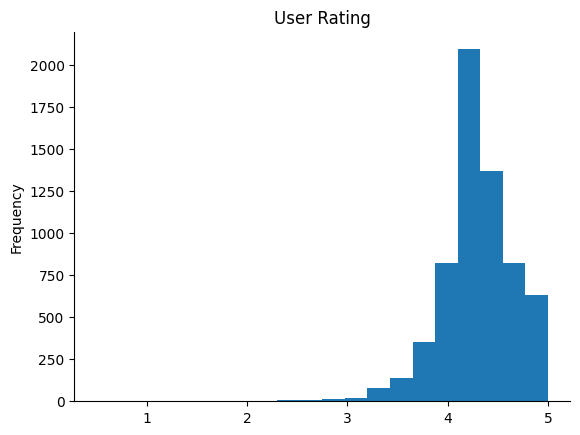

In [65]:
# @title User Rating

from matplotlib import pyplot as plt
df['User Rating'].plot(kind='hist', bins=20, title='User Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

Word frequency analysis to find top attributes

In [66]:
from collections import Counter # Import the Counter class from the collections module

# Flatten all tokens into a single list and count word frequencies
all_tokens = [word for tokens in df['cleaned_review'] for word in tokens]
word_counts = Counter(all_tokens)

# Get the top 10 most common words (attributes)
most_common_words = word_counts.most_common(10)

# Extract only the words for the top attributes
top_attributes = [word for word, freq in most_common_words]

# Display the top 10 attributes (most frequent words)
print("Top attributes found in beer reviews:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")


Top attributes found in beer reviews:
chocolate: 3775
dark: 3540
sweet: 3367
head: 3333
aroma: 3171
bottle: 2797
vanilla: 2590
black: 2493
coffee: 2474
taste: 2378


In [67]:
# Function to calculate lift between two attributes
from itertools import combinations # Import combinations from itertools module
import pandas as pd # Import pandas for DataFrame
import numpy as np # Import numpy for fill_diagonal

def calculate_lift(attribute1, attribute2, df):
    # Count occurrences of each attribute
    count_attr1 = df['cleaned_review'].apply(lambda x: attribute1 in x).sum()
    count_attr2 = df['cleaned_review'].apply(lambda x: attribute2 in x).sum()

    # Count occurrences of both attributes together
    count_both = df['cleaned_review'].apply(lambda x: attribute1 in x and attribute2 in x).sum()

    # Calculate probabilities
    p_attr1 = count_attr1 / len(df)
    p_attr2 = count_attr2 / len(df)
    p_both = count_both / len(df)

    # Calculate lift, avoiding division by zero
    return p_both / (p_attr1 * p_attr2) if p_attr1 * p_attr2 > 0 else 0

# Initialize the lift matrix as a DataFrame with index and columns from top attributes
lift_matrix = pd.DataFrame(index=top_attributes, columns=top_attributes)

# Populate the upper triangle of the matrix (including diagonal)
for attr1, attr2 in combinations(top_attributes, 2):
    lift_value = calculate_lift(attr1, attr2, df)
    lift_matrix.loc[attr1, attr2] = lift_value
    lift_matrix.loc[attr2, attr1] = lift_value  # Symmetric value

# Set diagonal elements to 1
np.fill_diagonal(lift_matrix.values, 1.0)

# Display the lift matrix
print("Calculating lift to check which attributes are mentioned together:")
print("\nLift matrix between top 10 attributes:")
lift_matrix

Calculating lift to check which attributes are mentioned together:

Lift matrix between top 10 attributes:


,chocolate,dark,sweet,head,aroma,bottle,vanilla,black,coffee,taste
chocolate,1.0,1.593455,1.23817,1.373847,1.238356,1.243985,1.75449,1.758169,1.93176,1.268575
dark,1.593455,1.0,1.318165,1.36394,1.26773,1.320298,1.491219,1.394457,1.494884,1.296762
sweet,1.23817,1.318165,1.0,1.227746,1.281876,1.297353,1.321902,1.255571,1.140226,1.258771
head,1.373847,1.36394,1.227746,1.0,1.348447,1.263594,1.333192,1.566354,1.444983,1.30233
aroma,1.238356,1.26773,1.281876,1.348447,1.0,1.184764,1.255713,1.295972,1.226337,1.472251
bottle,1.243985,1.320298,1.297353,1.263594,1.184764,1.0,1.351795,1.303825,1.167632,1.175535
vanilla,1.75449,1.491219,1.321902,1.333192,1.255713,1.351795,1.0,1.648862,1.714233,1.273092
black,1.758169,1.394457,1.255571,1.566354,1.295972,1.303825,1.648862,1.0,1.974856,1.296767
coffee,1.93176,1.494884,1.140226,1.444983,1.226337,1.167632,1.714233,1.974856,1.0,1.324205
taste,1.268575,1.296762,1.258771,1.30233,1.472251,1.175535,1.273092,1.296767,1.324205,1.0


Selecting attributes having highest lift

In [68]:
top_3_attributes_selected = ['coffee', 'black', 'chocolate']


In [69]:
top_3_cust_attr_pref = " ".join(top_3_attributes_selected)
top_3_cust_attr_pref

'coffee black chocolate'

# TASK C

In [70]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Load customer-specified attributes from a file - our current file loads coffee, black and vanilla as three attributes specified by the customer

attributes_file_path = '/content/attributes.txt'


with open(attributes_file_path, 'r', encoding='ISO-8859-1') as f:
    customer_attributes = [line.strip().lower() for line in f.readlines()]  # Lowercase for consistency

# Combine customer attributes into a single string
attributes_text = ' '.join(customer_attributes)

# Preprocess the reviews by removing special characters and converting to lowercase
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase for consistency
    return text

# Assume df contains the product reviews
df['cleaned_review'] = df['Product Review'].apply(preprocess_text)

# Prepare corpus for vectorization
corpus = df['cleaned_review'].tolist() + [attributes_text]
corpus = [preprocess_text(review) for review in corpus]  # Ensure consistent preprocessing

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus into a bag-of-words model
X = vectorizer.fit_transform(corpus)
X_normalized = normalize(X, norm='l2')

# Extract vectors for reviews and attributes
review_vectors = X_normalized[:-1]  # All vectors except the last one
attributes_vector = X_normalized[-1]  # The last vector is the customer attributes

# Compute cosine similarity between each review and the attributes
similarity_scores = cosine_similarity(review_vectors, attributes_vector.reshape(1, -1)).flatten()

# Add similarity scores to the DataFrame
df['similarity_score'] = similarity_scores

# Create output DataFrame with product name, product review, and similarity score
output_df = df[['Product Name', 'Product Review', 'similarity_score']]

# Display the output DataFrame
output_df = output_df.sort_values(by='similarity_score', ascending=False)
output_df.head(10)

,Product Name,Product Review,similarity_score
665,Toppling Goliath Mornin' Delight,Bottle. Color black with medium head. Aroma ro...,0.577350
3896,Funky Buddha Morning Wood,"Pours black with a beige head, aroma of chocol...",0.545545
3623,Bell's Expedition Stout,"Bottle from systembolaget. \r\nPours black, br...",0.544331
4187,Toppling Goliath Assassin,"A: Pitch black, no head N: Chocolate syrup, bo...",0.536056
1878,AleSmith Speedway Stout - Barrel-Aged Vietname...,Bottle at Bratislava Beer Tasting 12/23. Pours...,0.536056
1333,Bell's Black Note Stout,"strong malty, moderate chocolate and coffee no...",0.536056
3528,Bell's Expedition Stout,"12oz bottle at home. Pours an inky black, smal...",0.528271
3525,Bell's Expedition Stout,"Smell is oats, chocolate, coffee. Pitch black ...",0.527046
5635,Mikkeller Beer Geek Brunch Weasel,"0,33l bottle. Pours jet black with tan head. H...",0.522233
195,Närke Kaggen Stormaktsporter,"@Bbf’19, Thick black, Creamy head, sweet, roas...",0.522233


# Task D

In [71]:
! pip install vaderSentiment
#Run only if you have not installed VADER before

In [72]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [73]:
obj = SentimentIntensityAnalyzer()
output_df['Sentiment'] = output_df['Product Review'].apply(lambda review: obj.polarity_scores(review)['compound']) #Taking the compound score from Vader

In [74]:
output_df.sort_values('Sentiment')

,Product Name,Product Review,similarity_score,Sentiment
4145,Toppling Goliath Assassin,Whalez Share @ Browariat. 12.01.2019 Assassin ...,0.000000,-0.9884
4917,Bell's Expedition Stout - Bourbon Barrel-Aged,Bell's Brewery - Bourbon Barrel-Aged Expeditio...,0.026216,-0.9822
4433,Cigar City Hunahpu's Imperial Stout - Bourbon ...,Cigar City Brewing - Hunahpu’s Bourbon Barrel ...,0.000000,-0.9819
675,Toppling Goliath Mornin' Delight,Toppling Goliath Brewing Co. - Mornin' Delight...,0.022663,-0.9787
1780,Perennial Abraxas - Barrel-Aged,Tap @ MBCC 2018. \n\nBarrel Aged Abraxas 2017....,0.000000,-0.9749
...,...,...,...,...
1786,Perennial Abraxas - Barrel-Aged,"Perennial's most highly acclaimed product, a r...",0.076222,0.9987
1571,Founders CBS (Canadian Breakfast Stout),"Finally - Beer #11 of my 10,00th Beer Mileston...",0.052961,0.9987
298,Närke Kaggen Stormaktsporter,2007 nip bottle at Akkurat in Stockholm. A fe...,0.052595,0.9989
822,Russian River Pliny the Younger,Arguably the most sought-after IPA in the worl...,0.000000,0.9990


In [75]:
top_positive_sentiments = output_df.sort_values(by='Sentiment', ascending=False).drop_duplicates(subset='Product Name').head(3)

top_negative_sentiments = output_df.sort_values(by='Sentiment', ascending=True).drop_duplicates(subset='Product Name').head(3)

print("Top 3 Unique Products with Positive Sentiment Scores:")
top_positive_sentiments[['Product Name','Sentiment']]



Top 3 Unique Products with Positive Sentiment Scores:


,Product Name,Sentiment
5,Toppling Goliath Kentucky Brunch,0.9993
822,Russian River Pliny the Younger,0.9990
298,Närke Kaggen Stormaktsporter,0.9989


In [76]:
print("\nTop 3 Unique Products with Negative Sentiment Scores:")
top_negative_sentiments[['Product Name','Sentiment']]


Top 3 Unique Products with Negative Sentiment Scores:


,Product Name,Sentiment
4145,Toppling Goliath Assassin,-0.9884
4917,Bell's Expedition Stout - Bourbon Barrel-Aged,-0.9822
4433,Cigar City Hunahpu's Imperial Stout - Bourbon ...,-0.9819


### TASK E

In [77]:
output_df['Evaluation Score'] = output_df['similarity_score'] * output_df['Sentiment']

In [78]:
output_df = output_df.sort_values(by='Evaluation Score', ascending = False)

In [79]:
output_df_bow = output_df
top_3_bow = output_df.groupby('Product Name')['Evaluation Score'].mean().sort_values(ascending=False)[:3].to_frame().reset_index()
top_3_bow

,Product Name,Evaluation Score
0,AleSmith Speedway Stout - Barrel-Aged Vietname...,0.144336
1,Modern Times Monster Tones,0.135092
2,Toppling Goliath Kentucky Brunch,0.125989


Based on evaluation score, we recommend above 3 products to customer

### TASK F

In [80]:
!python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [82]:


# Function to compute the average word vector for a document
def get_average_vector(text, model):
    doc = model(text)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros((model.vocab.vectors_length,))

# Calculate the word vector for the customer-specified attributes
attributes_vector = get_average_vector(attributes_text, nlp)

# Function to check if a review mentions any customer attributes (Bag-of-Words)
def mentions_attribute_bow(review, attributes):
    for attribute in attributes:
        if attribute in review:
            return True
    return False

# Calculate the percentage of reviews mentioning attributes (BoW)
def percentage_reviews_mentioning_bow(df, attributes):
    df['mentions_attribute_bow'] = df['cleaned_review'].apply(lambda review: mentions_attribute_bow(review, attributes))
    products = df['Product Name'].unique()
    percentages_bow = {}

    for product in products:
        product_reviews = df[df['Product Name'] == product]
        percentage_mentioning = product_reviews['mentions_attribute_bow'].mean() * 100  # Convert to percentage
        percentages_bow[product] = percentage_mentioning

    return percentages_bow

# Calculate the percentage of reviews mentioning attributes (Word Vectors)
def percentage_reviews_mentioning_spacy(df, attributes_vector, threshold=0.5):
    df['review_vector'] = df['cleaned_review'].apply(lambda review: get_average_vector(review, nlp))
    df['similarity_score_spacy'] = df['review_vector'].apply(lambda vec: cosine_similarity([vec], [attributes_vector])[0][0])

    # Check if similarity score is above the threshold
    df['mentions_attribute_spacy'] = df['similarity_score_spacy'].apply(lambda score: score > threshold)

    products = df['Product Name'].unique()
    percentages_spacy = {}

    for product in products:
        product_reviews = df[df['Product Name'] == product]
        percentage_mentioning = product_reviews['mentions_attribute_spacy'].mean() * 100  # Convert to percentage
        percentages_spacy[product] = percentage_mentioning

    return percentages_spacy


# Calculate % of reviews mentioning attributes (BoW)
percentages_bow = percentage_reviews_mentioning_bow(df, customer_attributes)

# Calculate % of reviews mentioning attributes (Word Vectors)
percentages_spacy = percentage_reviews_mentioning_spacy(df, attributes_vector)

# Compare the two methods
comparison_df = pd.DataFrame({
    'Product Name': percentages_bow.keys(),
    'Percentage Mentioning (BoW)': percentages_bow.values(),
    'Percentage Mentioning (Word Vectors)': percentages_spacy.values()
})


In [83]:

comparison_df['Difference'] = comparison_df['Percentage Mentioning (Word Vectors)'] - comparison_df['Percentage Mentioning (BoW)']
comparison_df = comparison_df.sort_values(by='Difference', ascending=False)
comparison_df

,Product Name,Percentage Mentioning (BoW),Percentage Mentioning (Word Vectors),Difference
18,Hill Farmstead Ann,1.526718,94.656489,93.129771
45,Cantillon La Vie est Belge,1.219512,86.585366,85.365854
42,Three Floyds Dreadnaught,0.666667,82.000000,81.333333
48,3 Fonteinen Framboos (Framboise),2.000000,81.333333,79.333333
47,Schramm's Red Agnes,14.782609,93.043478,78.260870
41,Superstition Endovelicus,17.910448,95.522388,77.611940
33,Hill Farmstead Aaron,18.666667,89.333333,70.666667
39,The Alchemist Heady Topper,0.666667,70.000000,69.333333
16,Schramm's The Statement Reserve,23.636364,92.727273,69.090909
26,Russian River Pliny the Elder,2.666667,70.666667,68.000000


In [84]:


# Function to compute the average word vector for a document
def get_average_vector(text, model):
    doc = model(text)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros((model.vocab.vectors_length,))

# Compute average word vectors for each review and the customer attributes
df['review_vector'] = df['cleaned_review'].apply(lambda review: get_average_vector(review, nlp))
attributes_vector = get_average_vector(attributes_text, nlp)

# Compute cosine similarity between each review vector and the attributes vector
df['similarity_score_spacy'] = df['review_vector'].apply(lambda vec: cosine_similarity([vec], [attributes_vector])[0][0])

# Sort the DataFrame by similarity score
output_df_spacy = df[['Product Name', 'Product Review', 'similarity_score_spacy']]

# Display the top reviews based on word vectors similarity score
output_df_spacy = output_df_spacy.sort_values(by='similarity_score_spacy', ascending=False)

# Compare with the previous BoW-based recommendations
output_df_bow_1 = output_df[['Product Name', 'Product Review', 'similarity_score']]

# Display both results side by side for comparison
comparison_df = pd.merge(output_df_bow_1, output_df_spacy, on=['Product Name', 'Product Review'], suffixes=('_bow', '_spacy'))
comparison_df


,Product Name,Product Review,similarity_score,similarity_score_spacy
0,Firestone Walker Parabola,"0,355l bottle, courtesy of MrBubbler, many tha...",0.502625,0.752056
1,Mikkeller Beer Geek Brunch Weasel,Appearance: black with big brown head.\r\nArom...,0.510310,0.798857
2,AleSmith Speedway Stout,"(Bottle) Black colour with frothy, beige head....",0.448111,0.745890
3,AleSmith Speedway Stout - Barrel-Aged Vietname...,"Bottle @ BBT 12/2023\nF: medium, tanned, avera...",0.494872,0.801707
4,Bell's Black Note Stout,"strong malty, moderate chocolate and coffee no...",0.536056,0.673882
...,...,...,...,...
6358,AleSmith Speedway Stout,Bottle at home bought from Beer Gonzo a few ye...,0.365148,0.673091
6359,Cigar City Hunahpu's Imperial Stout,"Bottle from trade in US. Black color, beige he...",0.352673,0.824073
6360,Bottle Logic Fundamental Observation,"Draught at Bottle Logic. Black color, beige he...",0.355335,0.824029
6361,Founders KBS (Kentucky Breakfast Stout),"Aroma of chocolate, coffee, vanilla, bourbon d...",0.416667,0.733684


In [85]:
comparison_df['Sentiment'] = output_df['Product Review'].apply(lambda review: obj.polarity_scores(review)['compound'])

In [86]:
output_df_spacy = comparison_df
output_df_spacy['Evaluation Score']= comparison_df['similarity_score_spacy'] * output_df_spacy['Sentiment']
output_df_spacy = output_df_spacy.sort_values(by='Evaluation Score', ascending = False)
top_3_spacy = output_df_spacy.groupby('Product Name')['Evaluation Score'].mean().sort_values(ascending=False)[:3].to_frame().reset_index()

print("Top 3 recommendations of Beers based on Spacy:")
top_3_spacy

Top 3 recommendations of Beers based on Spacy:


,Product Name,Evaluation Score
0,Modern Times Monster Tones,0.473466
1,Schramm's The Statement Reserve,0.430752
2,Superstition Black Berry White,0.408047


In [87]:
# percentage_reviews_mentioning_attribute using Spacy

def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage


#top 3 recommendations in 'output_df_spacy'
for _, row in top_3_spacy.iterrows():
  product_name = row['Product Name']
  for attribute in customer_attributes:  # Loop through each attribute specified by the customer
      percentage = percentage_reviews_mentioning_attribute(df, product_name, attribute)
      print(f"For product '{product_name}', {percentage:.2f}% of reviews mention the attribute '{attribute}'.")


For product 'Modern Times Monster Tones', 53.57% of reviews mention the attribute 'coffee'.
For product 'Modern Times Monster Tones', 67.86% of reviews mention the attribute 'black'.
For product 'Modern Times Monster Tones', 73.21% of reviews mention the attribute 'chocolate'.
For product 'Schramm's The Statement Reserve', 0.00% of reviews mention the attribute 'coffee'.
For product 'Schramm's The Statement Reserve', 21.82% of reviews mention the attribute 'black'.
For product 'Schramm's The Statement Reserve', 3.64% of reviews mention the attribute 'chocolate'.
For product 'Superstition Black Berry White', 0.00% of reviews mention the attribute 'coffee'.
For product 'Superstition Black Berry White', 76.64% of reviews mention the attribute 'black'.
For product 'Superstition Black Berry White', 44.86% of reviews mention the attribute 'chocolate'.


In [88]:
#percentage_reviews_mentioning_attribute using BOW

def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage


#top 3 recommendations in 'output_df_bow'
for _, row in top_3_bow.iterrows():
  product_name = row['Product Name']
  for attribute in customer_attributes:  # Loop through each attribute specified by the customer
      percentage = percentage_reviews_mentioning_attribute(df, product_name, attribute)
      print(f"For product '{product_name}', {percentage:.2f}% of reviews mention the attribute '{attribute}'.")


For product 'AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee', 87.33% of reviews mention the attribute 'coffee'.
For product 'AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee', 59.33% of reviews mention the attribute 'black'.
For product 'AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee', 60.00% of reviews mention the attribute 'chocolate'.
For product 'Modern Times Monster Tones', 53.57% of reviews mention the attribute 'coffee'.
For product 'Modern Times Monster Tones', 67.86% of reviews mention the attribute 'black'.
For product 'Modern Times Monster Tones', 73.21% of reviews mention the attribute 'chocolate'.
For product 'Toppling Goliath Kentucky Brunch', 72.00% of reviews mention the attribute 'coffee'.
For product 'Toppling Goliath Kentucky Brunch', 58.67% of reviews mention the attribute 'black'.
For product 'Toppling Goliath Kentucky Brunch', 55.33% of reviews mention the attribute 'chocolate'.



Analysis:<br>
Considering the percentage of reviews mentioning specific attributes as a key metric, we found that the Bag-of-Words (BoW) model provides more accurate recommendations than SpaCy. While the SpaCy model showed high overall similarity scores, it had a lower percentage of reviews mentioning sought-after attributes, such as coffee, black, or vanilla. This discrepancy led us to favor the BoW model for generating recommendations.

Additionally, during our qualitative assessment of SpaCy's recommendations, we observed several products being suggested despite having 0 mentions of, or related terms about, the user-defined attributes in their reviews. This raised concerns about the model's reliability, further reinforcing our decision to choose the BoW model.

Lastly, given that this website targets a specific user base and product range, we anticipate that most reviews will be relevant even when using the BoW model, making it a suitable choice for our recommendation needs.

TASK G

In [89]:
#get average User Rating for each Product Name of beer and get total ratings for each and form a new df_highest_rated

# Group by 'Product Name' and calculate the average 'User Rating' and total ratings
df_highest_rated = df.groupby('Product Name')['User Rating'].agg(['mean', 'count'])

# Rename the columns for better readability
df_highest_rated = df_highest_rated.rename(columns={'mean': 'Average User Rating', 'count': 'Total Ratings'})

# Sort the DataFrame by 'Average User Rating' in descending order to get the highest-rated products
df_highest_rated = df_highest_rated.sort_values(by='Average User Rating', ascending=False)
# Get the top 3 highest-rated products
top_3_highest_rated = df_highest_rated.head(3).reset_index() # Reset the index to make 'Product Name' a column

# Display the top 3 highest-rated products
print("Top 3 Highest-Rated Products:")
top_3_highest_rated[['Product Name', 'Average User Rating', 'Total Ratings']]


Top 3 Highest-Rated Products:


,Product Name,Average User Rating,Total Ratings
0,Toppling Goliath Kentucky Brunch,4.568667,150
1,Sahtipaja MeadMe Batch #2 - Bourbon Vanilla,4.529167,24
2,Schramm's The Heart of Darkness,4.481553,103


In [90]:
bow_evaluated_beers = output_df.groupby('Product Name')['Evaluation Score'].mean().sort_values(ascending=False).to_frame().reset_index()

In [91]:
#percentage_reviews_mentioning_attribute using AVG_RATINGS

def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage


#top 3 recommendations in 'top_3_highest_rated'
for _, row in top_3_highest_rated.iterrows():
  product_name = row['Product Name']
  for attribute in customer_attributes:  # Loop through each attribute specified by the customer
      percentage = percentage_reviews_mentioning_attribute(df, product_name, attribute)
      print(f"For product '{product_name}', {percentage:.2f}% of reviews mention the attribute '{attribute}'.")


For product 'Toppling Goliath Kentucky Brunch', 72.00% of reviews mention the attribute 'coffee'.
For product 'Toppling Goliath Kentucky Brunch', 58.67% of reviews mention the attribute 'black'.
For product 'Toppling Goliath Kentucky Brunch', 55.33% of reviews mention the attribute 'chocolate'.
For product 'Sahtipaja MeadMe Batch #2 - Bourbon Vanilla', 0.00% of reviews mention the attribute 'coffee'.
For product 'Sahtipaja MeadMe Batch #2 - Bourbon Vanilla', 37.50% of reviews mention the attribute 'black'.
For product 'Sahtipaja MeadMe Batch #2 - Bourbon Vanilla', 8.33% of reviews mention the attribute 'chocolate'.
For product 'Schramm's The Heart of Darkness', 0.00% of reviews mention the attribute 'coffee'.
For product 'Schramm's The Heart of Darkness', 43.69% of reviews mention the attribute 'black'.
For product 'Schramm's The Heart of Darkness', 5.83% of reviews mention the attribute 'chocolate'.


In [92]:
def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage


# Create an empty list to store the results
data = []

# Iterate through top_3_bow rows
for _, row in top_3_highest_rated.iterrows():
  product_name = row['Product Name']
  row_data = {'Product Name': product_name}
  for attribute in customer_attributes:
    percentage = percentage_reviews_mentioning_attribute(df, product_name, attribute)
    row_data[attribute] = percentage
  data.append(row_data)

# Convert the list of dictionaries to a DataFrame
attribute_percentage_df_rating = pd.DataFrame(data)

# Display the DataFrame
attribute_percentage_df_rating

t2 = output_df_bow.groupby('Product Name')[['Evaluation Score','similarity_score']].mean().sort_values(by='Evaluation Score',ascending=False).reset_index()
merged_df = pd.merge(attribute_percentage_df_rating, t2, on='Product Name', how='left')

print('Recommendation as per highest avg Ratings:')
merged_df


Recommendation as per highest avg Ratings:


,Product Name,coffee,black,chocolate,Evaluation Score,similarity_score
0,Toppling Goliath Kentucky Brunch,72.0,58.666667,55.333333,0.125989,0.157279
1,Sahtipaja MeadMe Batch #2 - Bourbon Vanilla,0.0,37.500000,8.333333,0.024674,0.046784
2,Schramm's The Heart of Darkness,0.0,43.689320,5.825243,0.028428,0.040748


In [93]:

def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage


# Create an empty list to store the results
data = []

# Iterate through top_3_bow rows
for _, row in top_3_bow.iterrows():
  product_name = row['Product Name']
  row_data = {'Product Name': product_name}
  for attribute in customer_attributes:
    percentage = percentage_reviews_mentioning_attribute(df, product_name, attribute)
    row_data[attribute] = percentage
  data.append(row_data)

# Convert the list of dictionaries to a DataFrame
attribute_percentage_df_bow = pd.DataFrame(data)

# Display the DataFrame
attribute_percentage_df_bow


t1 = output_df_bow.groupby('Product Name')[['Evaluation Score','similarity_score']].mean().sort_values(by='Evaluation Score',ascending=False).reset_index()[:3]
merged_df = pd.merge(attribute_percentage_df_bow, t1, on='Product Name', how='left')
print('Recommendation as per Bag of Words Model:')
merged_df

Recommendation as per Bag of Words Model:


,Product Name,coffee,black,chocolate,Evaluation Score,similarity_score
0,AleSmith Speedway Stout - Barrel-Aged Vietname...,87.333333,59.333333,60.000000,0.144336,0.224770
1,Modern Times Monster Tones,53.571429,67.857143,73.214286,0.135092,0.226816
2,Toppling Goliath Kentucky Brunch,72.000000,58.666667,55.333333,0.125989,0.157279


**Analysis:**<br>
Bag of Words Model Recommendations<br>
AleSmith Speedway Stout - Barrel-Aged Vietnamese CoffeeHighest evaluation score (0.144336) and strong similarity score (0.224770)
Excels in coffee (87.333333), with good black (59.333333) and chocolate (60.0) scores
<br>
Modern Times Monster TonesSecond-highest evaluation score (0.135092) and highest similarity score (0.226816)
Strong in chocolate (73.214286) and black (67.857143), moderate in coffee (53.571429)
<br>
Toppling Goliath Kentucky BrunchThird-highest evaluation score (0.125989), lower similarity score (0.157279)
Good coffee score (72.0), moderate in black and chocolate
<br>
Highest Average Ratings<br>
The top-rated beers (except Toppling Goliath Kentucky Brunch) have significantly lower scores for coffee, chocolate, and overall evaluation and similarity scores, suggesting they don't align well with the user's specific flavor preferences.<br>
Conclusion:
The Bag of Words model provides recommendations more tailored to the user's preferences for coffee, black, and chocolate flavors, with AleSmith Speedway Stout standing out as the top recommendation.

### TASK H

In [94]:
import random

df2 = pd.read_csv(file_path)
unique_beers = df2['Product Name'].unique()

# Choose 10 random unique beers
random_beers = random.sample(list(unique_beers), 10)

ten_random_beers = random_beers
print("10 Randomly Chosen Beers:")
for _ in ten_random_beers:
  print(_)
print("\n")
print("selected Beer= ",ten_random_beers[0])
df_new = df2[df2['Product Name'] == ten_random_beers[0]]
print("\n")
df_new

10 Randomly Chosen Beers:
Superstition Grand Cru Berry - F.O. Barrel Aged
Funky Buddha Morning Wood
Superstition Grand Cru Berry
Hill Farmstead Ann
AleSmith Speedway Stout - Bourbon Barrel Aged
Toppling Goliath Assassin - Vanilla Bean
Toppling Goliath Kentucky Brunch
Toppling Goliath Mornin' Delight
Superstition Blue Berry White
Närke Kaggen Stormaktsporter


selected Beer=  Superstition Grand Cru Berry - F.O. Barrel Aged




,Product Name,Product Review,User Rating
1092,Superstition Grand Cru Berry - F.O. Barrel Aged,Stated at a few different festivals. Dark colo...,4.5
1093,Superstition Grand Cru Berry - F.O. Barrel Aged,RateBeer Best 2017. Pours sort of a cabernet c...,4.2
1094,Superstition Grand Cru Berry - F.O. Barrel Aged,Rami Rami is drinking a Grand Cru Berry (Funda...,4.7
1095,Superstition Grand Cru Berry - F.O. Barrel Aged,"Na pierwszym planie wyraźna porzeczka, owoce l...",4.8
1096,Superstition Grand Cru Berry - F.O. Barrel Aged,100 ocena na Ratebeer. Bogaty aromat owocowy. ...,4.8
1097,Superstition Grand Cru Berry - F.O. Barrel Aged,"Symfonia smaków o aromatow, zjawiskowy trunek,...",4.9
1098,Superstition Grand Cru Berry - F.O. Barrel Aged,"WOW. Mega słodkie, bardzo wyraźna porzeczka, m...",4.7
1099,Superstition Grand Cru Berry - F.O. Barrel Aged,Svartvit\r\nSvartvit\r\nminder dan een minuut ...,4.8
1100,Superstition Grand Cru Berry - F.O. Barrel Aged,Flight sample at the source. Dark purple. Stil...,4.8
1101,Superstition Grand Cru Berry - F.O. Barrel Aged,From tap at MBCC. Hazy ruby red purple color w...,4.6


In [95]:
# Preprocess the reviews by removing special characters and stopwords
def preprocess_text(text):
    common_words_beer = ['beer','bottle','aroma','head','taste','de','alchol','best','one','hops','hop','flavour','flavor']
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    #tokens = [word for word in text.split() if word not in stop_words]
    tokens = [word for word in text.split() if word not in common_words_beer and word not in stop_words ]
    return tokens

df_new['cleaned_review'] = df_new['Product Review'].apply(preprocess_text)
# Word Frequency Analysis
word_counts = Counter()
for tokens in df_new['cleaned_review']:
    word_counts.update(tokens)

# Get the top 10 most common words (assumed to be the top attributes)
most_common_words = word_counts.most_common(3)
top_attributes = [word for word, freq in most_common_words]

customer_attributes = top_attributes
attributes_text = ' '.join(top_attributes)

print(' {} are the attributes associate with the beer are : {}'.format(ten_random_beers[0], attributes_text))

 Superstition Grand Cru Berry - F.O. Barrel Aged are the attributes associate with the beer are : honey sweet berries


<ipython-input-95-667a05b5a174>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['cleaned_review'] = df_new['Product Review'].apply(preprocess_text)


In [96]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_filtered = df[df['Product Name'].isin(ten_random_beers)]
df_filtered

# Combine customer attributes into a single string
#attributes_text = ' '.join(customer_attributes)

# Preprocess the reviews by removing special characters and converting to lowercase
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase for consistency
    return text

# Assume df contains the product reviews
df_filtered['cleaned_review'] = df_filtered['Product Review'].apply(preprocess_text)

# Prepare corpus for vectorization
# Add a check to ensure reviews are correctly processed
corpus = df_filtered['cleaned_review'].tolist() + [attributes_text]
corpus = [preprocess_text(review) for review in corpus]  # Ensure consistent preprocessing

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus into a bag-of-words model
X = vectorizer.fit_transform(corpus)

# Extract vectors for reviews and attributes
review_vectors = X[:-1]  # All vectors except the last one
attributes_vector = X[-1]  # The last vector is the customer attributes

# Compute cosine similarity between each review and the attributes
similarity_scores = cosine_similarity(review_vectors, attributes_vector.reshape(1, -1)).flatten()

# Add similarity scores to the DataFrame
df_filtered['similarity_score'] = similarity_scores

# Create output DataFrame with product name, product review, and similarity score
output_df = df_filtered[['Product Name', 'Product Review', 'similarity_score']]

# Display the output DataFrame
output_df.sort_values(by='similarity_score', ascending = False)

mask = output_df['similarity_score'] > 0

output_df[mask]


<ipython-input-96-baa08150967b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cleaned_review'] = df_filtered['Product Review'].apply(preprocess_text)
<ipython-input-96-baa08150967b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['similarity_score'] = similarity_scores


,Product Name,Product Review,similarity_score
5,Toppling Goliath Kentucky Brunch,There are not hundreds of beers on my bucketli...,0.006714
6,Toppling Goliath Kentucky Brunch,The perfect stout. Not overly sweet. Nice barr...,0.123091
7,Toppling Goliath Kentucky Brunch,"Pours a thick, dark, almost-oily black, with v...",0.094916
10,Toppling Goliath Kentucky Brunch,"Bottle@Whale-kill, Grindsted. Aroma of roasted...",0.091287
12,Toppling Goliath Kentucky Brunch,12 oz bottle. Pours nearly pitch black color a...,0.045326
...,...,...,...
5938,Toppling Goliath Assassin - Vanilla Bean,"Updated with 2019 bottle, where I had a much m...",0.130535
5939,Toppling Goliath Assassin - Vanilla Bean,"Black pour with an off white head. Vanilla, ch...",0.125988
5940,Toppling Goliath Assassin - Vanilla Bean,The waxed bottle pours with a thick dark mahog...,0.108679
5943,Toppling Goliath Assassin - Vanilla Bean,"Sample at Peg’s. Dark brown black, oily cons. ...",0.129099


In [97]:
similar_beer = output_df.groupby('Product Name')['similarity_score'].mean().sort_values(ascending=False).reset_index()#[:2]
if ten_random_beers[0] == similar_beer['Product Name'].values[0]:
  print("The most similar beer to {} by similarity_score is {}".format(ten_random_beers[0],similar_beer['Product Name'].values[1]))
else:
  print("The most similar beer to {} by similarity_score is {}".format(ten_random_beers[0],similar_beer['Product Name'].values[1]))

The most similar beer to Superstition Grand Cru Berry - F.O. Barrel Aged by similarity_score is Superstition Blue Berry White


In [98]:
# Similar but highly rated by sentiment analysis
obj = SentimentIntensityAnalyzer()  # Creating the SentimentIntensityAnalyzer object
output_df['Sentiment'] = output_df['Product Review'].apply(lambda review: obj.polarity_scores(review)['compound']) #Taking the compound score from Vader
output_df['Evaluation Score'] = output_df['similarity_score'] * output_df['Sentiment']



<ipython-input-98-d434631aaabd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Sentiment'] = output_df['Product Review'].apply(lambda review: obj.polarity_scores(review)['compound']) #Taking the compound score from Vader
<ipython-input-98-d434631aaabd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Evaluation Score'] = output_df['similarity_score'] * output_df['Sentiment']


In [99]:
top_similar = output_df.groupby('Product Name')['Evaluation Score'].mean().sort_values(ascending=False).to_frame().reset_index()
if ten_random_beers[0] == top_similar['Product Name'].values[0]:
  print('Similar beer to {} and highly rated by sentiment analysis is: \n {} by evaluation score {}'.format(ten_random_beers[0],top_similar['Product Name'].values[1],top_similar['Evaluation Score'].values[1]))
else:
  print('Similar beer to {} and highly rated by sentiment analysis is: \n {} by evaluation score {}'.format(ten_random_beers[0],top_similar['Product Name'].values[0],top_similar['Evaluation Score'].values[0]))

Similar beer to Superstition Grand Cru Berry - F.O. Barrel Aged and highly rated by sentiment analysis is: 
 Superstition Grand Cru Berry by evaluation score 0.14819662175838857


In [100]:
#percentage_reviews_mentioning_attribute using AVG_RATINGS
def percentage_reviews_mentioning_attribute(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['Product Name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['cleaned_review'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage

if ten_random_beers[0] == top_similar['Product Name'].values[0]:
  top_similar=top_similar[1:2]
else:
  top_similar=top_similar[0:1]

#top 3 recommendations in 'top_3_highest_rated'
for _, row in top_similar[0:1].iterrows():
  product_name = row['Product Name']
  for attribute in customer_attributes:  # Loop through each attribute specified by the customer
      percentage = percentage_reviews_mentioning_attribute(df_filtered, product_name, attribute)
      print(f"For product '{product_name}', {percentage:.2f}% of reviews mention the attribute '{attribute}'.")

For product 'Superstition Grand Cru Berry', 52.75% of reviews mention the attribute 'honey'.
For product 'Superstition Grand Cru Berry', 65.93% of reviews mention the attribute 'sweet'.
For product 'Superstition Grand Cru Berry', 53.85% of reviews mention the attribute 'berries'.


Method and Logic

1. **Random Beer Selection**: The code reads in a dataset of beers, then randomly selects 10 unique beer names from this dataset. It designates the first beer from this selection as the "selected beer" to compare with others.

2. **Review Preprocessing**: It preprocesses the reviews by removing special characters and stopwords, specifically filtering out common beer-related words, to isolate meaningful attributes in each review.

3. **Attribute Extraction**: For the selected beer, it performs word frequency analysis to identify the top three most common words in the reviews, treating these as key attributes of the beer.

4. **Dataset Filtering**: The code filters the original dataset to retain only reviews for the 10 chosen beers. This reduced dataset is then used for similarity comparison.

5. **Bag-of-Words Model**: It vectorizes the preprocessed reviews and the identified attributes for the selected beer using the Bag-of-Words (BoW) approach, creating vectors for each review.

6. **Cosine Similarity Calculation**: Cosine similarity scores are calculated between each beer's review vectors and the vector representing the selected beer's attributes. This provides a measure of similarity based on shared terms.

7. **Finding Most Similar Beer**: The beer with the highest average similarity score (excluding the selected beer itself) is identified as the most similar beer.

8. **Sentiment-Adjusted Similarity**: Using VADER sentiment analysis, the code calculates a sentiment score for each review. It combines this sentiment score with the similarity score to produce an “evaluation score” that factors in both similarity and sentiment.

9. **Top Recommendation by Evaluation Score**: The beer with the highest evaluation score is identified as the most similar and positively rated beer based on sentiment analysis.

10. **Attribute Mention Percentage**: For the most similar beer, the code calculates the percentage of reviews mentioning each of the selected beer’s top three attributes. This gives insight into how strongly the similar beer shares specific attributes with the selected beer.